# Model Interpretation 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
%matplotlib inline
from sklearn.model_selection import train_test_split
import sys
from treeinterpreter import treeinterpreter

from pathlib import Path

import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score
import sklearn

import shap
import lime
import lime.lime_tabular

/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 3 Questions

objective based model



- Can we replicate the `feature_importances_` from sklearn?
- Can you interpret the 'black box'. Can you interpret an ensemble model? 

- Can you interpret non-tree models (SVM) feature importance(raw) / SHAP

 - (https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html) 
 - (https://github.com/marcotcr/lime)

In [2]:
# read in data
DATA_PATH = Path('data/')

train = pd.read_csv(DATA_PATH/'train.csv')
test = pd.read_csv(DATA_PATH/'test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
# create features for the model. 
def preprocess(df):
    """
    Main feature engineering function.
    """
    def mk_categoricals(df, prefixes=None, subsets=None):
        """
        Converts one-hot-encoded categorical to true categorical.
        prefixes: list of prefixes of one-hot-encoded categorical variables
                  e.g. for variables
                      abastaguadentro, =1 if water provision inside the dwelling
                      abastaguafuera, =1 if water provision outside the dwelling
                      abastaguano, =1 if no water provision
                  we provide prefix "abastagua"
        subsets: dictionary {name_of_feature: [columns], ...}
                 e.g. for variables
                     public, "=1 electricity from CNFL,  ICE,  ESPH/JASEC"
                     planpri, =1 electricity from private plant
                     noelec, =1 no electricity in the dwelling
                     coopele, =1 electricity from cooperative
                 we provide {"electricity": ['public', 'planpri', 'noelec', 'coopele']}
        """
        def mk_category(dummies):
            assert (dummies.sum(axis=1) <= 1).all()
            nans = dummies.sum(axis=1) != 1
            if nans.any():
                dummies = dummies.assign(_na=nans.astype(int))
            return dummies.idxmax(axis=1).astype('category')

        categoricals = pd.DataFrame()

        if prefixes:
            for prefix in prefixes:
                columns = df.columns[df.columns.str.startswith(prefix)]
                categoricals[prefix] = mk_category(df[columns])
        if subsets:
            for feature_name, subset in subsets.items():
                categoricals[feature_name] = mk_category(df[subset])

        return categoricals
    
    groupper = df.groupby('idhogar')
    interactions = (pd.DataFrame(dict(
                    head_escolari=df.parentesco1 * df.escolari,
                    head_female=df.parentesco1 * df.female,
                    head_partner_escolari=df.parentesco2 * df.escolari))
                    .groupby(df.idhogar)
                    .max())
    # basic interaction features
    
    my_features = (groupper.mean()[['escolari', 'age', 'hogar_nin', 
                                    'hogar_total', 'epared3', 'epared1',
                                    'etecho3', 'etecho1', 'eviv3', 'eviv1',
                                    'male', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 
                                    'r4m3','r4t1', 'r4t2', 'r4t3', 'v2a1', 'rooms', 
                                    'bedrooms', 'meaneduc', 'SQBdependency', 'rez_esc', 'refrig', 
                                    'tamviv', 'overcrowding']]
                   .join(groupper.std()[['escolari', 'age']], rsuffix='_std')
                   .join(groupper[['escolari', 'age']].min(), rsuffix="_min")
                   .join(groupper[['escolari', 'age']].max(), rsuffix="_max")
                   .join(groupper[['dis']].sum(), rsuffix="_sum")
                   # partially based on
                   # https://www.kaggle.com/taindow/predicting-poverty-levels-with-r
                   .assign(child_rate=lambda x: x.hogar_nin / x.hogar_total,
                           wrf=lambda x: x.epared3 - x.epared1 +
                                         x.etecho3 - x.etecho1 +
                                         x.eviv3 - x.eviv1,
                           # wrf is an integral feature that measure
                           # quality of the house
                           escolari_range=lambda x: x.escolari_max - x.escolari_min,
                           age_range=lambda x: x.age_max - x.age_min,
                           rent_per_individual=lambda x: x.v2a1 / x.r4t3,
                           rent_per_child=lambda x: x.v2a1 / x.r4t1,
                           rent_per_over65=lambda x: x.v2a1 / x.r4t3,
                           rent_per_room=lambda x: x.v2a1 / x.rooms,
                           rent_per_bedroom=lambda x: x.v2a1 / x.bedrooms,
                           rooms_per_individual=lambda x: x.rooms / x.r4t3,
                           rooms_per_child=lambda x: x.rooms / x.r4t1,
                           bedrooms_per_individual=lambda x: x.bedrooms / x.r4t3,
                           bedrooms_per_child=lambda x: x.bedrooms / x.r4t1,
                           years_schooling_per_individual=lambda x: x.escolari / x.r4t3,
                           years_schooling_per_adult=lambda x: x.escolari / (x.r4t3 - x.r4t1),
                          )
                   .drop(['hogar_nin', 'hogar_total', 'epared3', 'epared1',
                                   'etecho3', 'etecho1', 'eviv3', 'eviv1'], axis=1)
                   .join(interactions)
                   .join(groupper[['computer', 'television', 
                                   'qmobilephone', 'v18q1']]
                         .mean().sum(axis=1).rename('technics'))
                   # we provide integral technical level as a new feature 
                   .assign(technics_per_individual=lambda x: x.technics / x.r4t3,
                           technics_per_child=lambda x: x.technics / x.r4t1)
                   .join(mk_categoricals(groupper.mean(), 
                                prefixes=['lugar', 'area', 'tipovivi', 'energcocinar', 
                                          'sanitario', 'pared', 'piso','abastagua'],
                                subsets={'electricity': ['public', 'planpri', 'noelec', 'coopele']})))
    return my_features

In [4]:
X_train = preprocess(train)
X_test = preprocess(test)

# for some households, different Target values are given we will try to fix it by using mean
# subtract 1 to put in (0-4 range). Needed for LightGGM
y_train = train.groupby('idhogar').Target.mean().astype(int) - 1

In [5]:
# dummy variable categorical features, good for feature importance plots and needed for SVM
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [6]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# replace 'inf' with 99999 (needed for sklearn models)
X_train = X_train.apply(lambda x: x.replace(np.inf, 99999))
X_test = X_test.apply(lambda x: x.replace(np.inf, 99999))

# median encode missing values 
columns = X_train.columns
imputer = Imputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)


# split dataset into training and validation (so we can test some interprerability for some out-of-sample data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=100, test_size=100)


# scale data for SVM
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = ss.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

In [7]:
X_train.head()

,escolari,age,male,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,...,piso_pisonotiene,piso_pisoother,abastagua_abastaguadentro,abastagua_abastaguafuera,abastagua_abastaguano,electricity__na,electricity_coopele,electricity_noelec,electricity_planpri,electricity_public
1136,8.333333,23.0,0.666667,1.0,1.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
515,15.000000,65.0,0.500000,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1287,14.000000,25.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1264,3.200000,33.6,0.800000,0.0,4.0,4.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
642,7.666667,25.0,0.333333,0.0,1.0,1.0,0.0,2.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Run our 3 different model 

In [8]:
random_forest = RandomForestClassifier(n_estimators=300, min_samples_leaf=10, random_state=100)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

In [9]:
svm = SVC(kernel='rbf', probability=True, C=0.1, gamma=0.1, random_state=100)
svm.fit(X_train_scaled, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=100, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
default_param = {
    'objective': 'multiclass',
    'seed': 100,
    'num_classes': 4,
}

lgb_train = lgb.Dataset(X_train, y_train)

cv_results = lgb.cv(default_param, lgb_train, num_boost_round=10000,
                    early_stopping_rounds=100, nfold=5, verbose_eval=False)
lgb_model = lgb.train(default_param, lgb_train, num_boost_round=len(cv_results['multi_logloss-mean']))

Try 'droping' an input by using a constant for one of your input features. Then, train the network for each of the possible cases and see how your accuracy drops. Important inputs will provide the greatest benefit to overall accuracy.

In [11]:
# feature importance

def weighted_f1(y_pred, y_true):
    return f1_score(y_true, y_pred, average='weighted')

def weighted_f1_probs(preds, y_true):
    preds = preds.argmax(axis = 1)
    return f1_score(y_true, preds, average='weighted')

def feat_imp(model, X, y, metric):
    base_model = metric(model.predict(X), y)
    scores = {}
    for i in range(len(X.columns)):
        random_index = np.random.permutation(len(X))
        column = X.values[random_index, i]
        X_new = X.copy()
        X_new[X.columns[i]] = column 
        scores[X.columns[i]] = abs(metric(model.predict(X_new), y) - base_model)
    return sorted(scores.items(), key = lambda x: x[1], reverse=True)

def create_feature_importance_plot(clf, metric, model_name=None, top_k=10, ax=None):
    scores = feat_imp(clf, X_train, y_train, metric)
    pd.DataFrame(scores[:top_k], columns=['feature', 'importance']).set_index('feature').plot(kind='barh', ax=ax);
    plt.title('Feature Importance plot: Custom {}'.format(model_name))

# Can we replicate the Feature Importance plot from Sklearn? 

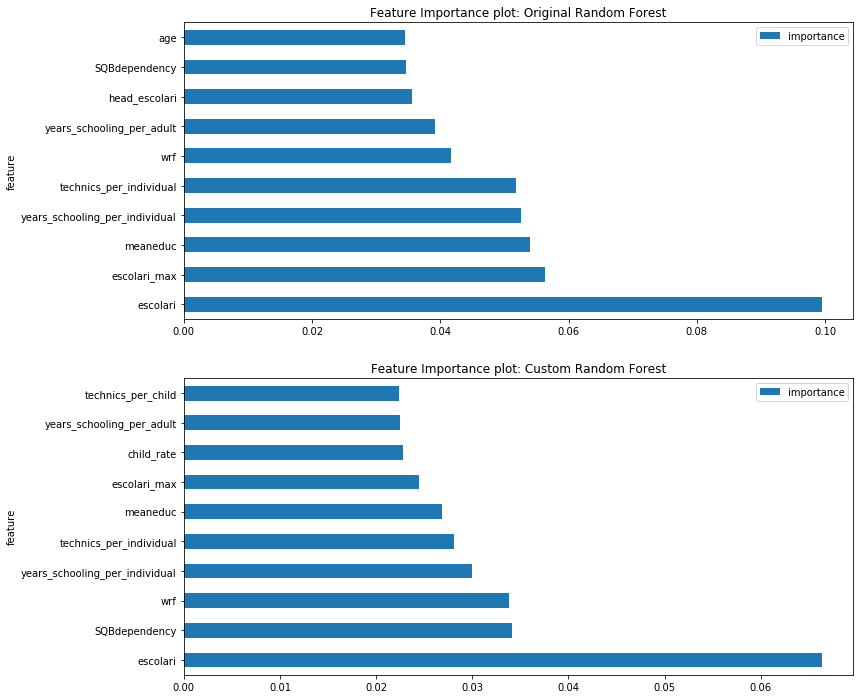

In [12]:
# random forest feature_importances_
fig, (ax, ax2) = plt.subplots(ncols=1, nrows=2)
fi = pd.DataFrame({'feature': X_train.columns, 'importance': random_forest.feature_importances_}).set_index(
                    'feature').sort_values('importance', ascending=False)
fi[:10].plot(kind='barh', ax=ax, figsize=(12, 12), title='Feature Importance plot: Original Random Forest')

create_feature_importance_plot(random_forest, weighted_f1, 'Random Forest', ax=ax2)

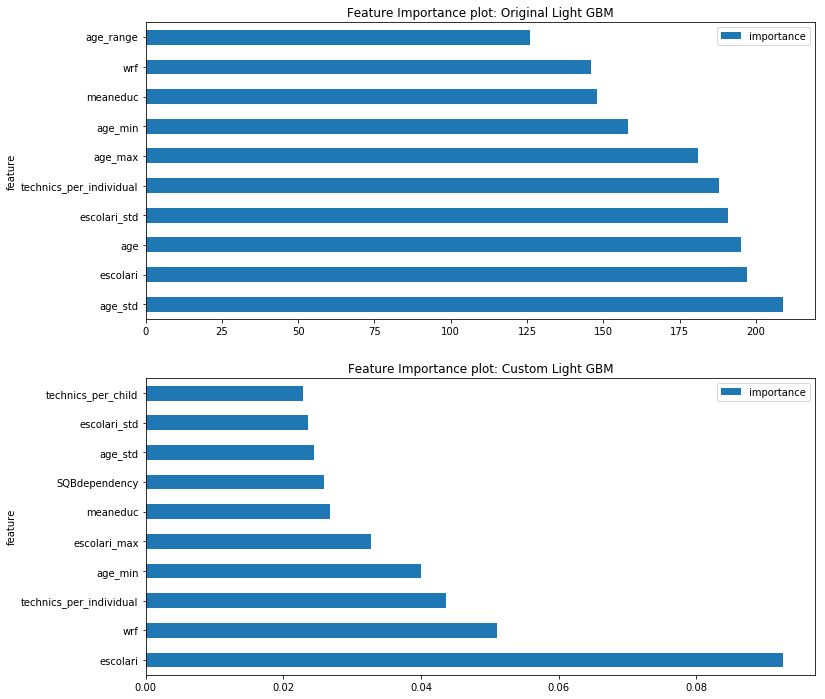

In [13]:
# light gbm feature_importances
fig, (ax, ax2) = plt.subplots(ncols=1, nrows=2)
fi = pd.DataFrame({'feature': X_train.columns, 'importance': lgb_model.feature_importance()}).set_index(
                    'feature').sort_values('importance', ascending=False)
fi[:10].plot(kind='barh', ax=ax, figsize=(12, 12), title='Feature Importance plot: Original Light GBM')

create_feature_importance_plot(lgb_model, weighted_f1_probs, 'Light GBM', ax=ax2)

# Can we interpret the 'black box'? 

In [14]:
# confidence intervals
def pred_ci(model, x_val, y_val, percentile = 95):   
    allTree_preds = np.stack([t.predict(x_val) for t in model.estimators_], axis = 0)
    
    err_down = np.percentile(allTree_preds, (100 - percentile) / 2.0, axis=0)
    err_up = np.percentile(allTree_preds, 100 - (100 - percentile) / 2.0, axis=0)
    
    ci = err_up - err_down
    yhat = model.predict(x_val)
    y = y_val
    
    df = pd.DataFrame()
    df['down'] = err_down 
    df['up'] = err_up
    df['y'] = y
    df['yhat'] = yhat
    df['deviation'] = (df['up'] - df['down'])/df['yhat']
    df.reset_index(inplace=True)
    df_sorted = df.iloc[np.argsort(df['deviation'])[::-1]]
    return df_sorted

In [15]:
pred_ci(random_forest, X_val[:1], y_val[:1])

,index,down,up,y,yhat,deviation
0,0,0.0,3.0,NaN,0,inf


In [16]:
row_value = 94

example_row = X_val.iloc[row_value:row_value+1]
example_pred = y_val[row_value]

pred, bias, obs = treeinterpreter.predict(random_forest, example_row)
print(pred, np.argmax(pred), example_pred)
ti = pd.DataFrame(list(zip(X_train.columns,  np.round(example_row.iloc[0], 2), obs[0][:, np.argmax(pred)])), 
             columns=['features', 'row_value', 'contribution']).sort_values('contribution', ascending=False)
ti = ti.merge(pd.DataFrame(np.round(X_train.median(),2), columns=['median']), left_on='features', right_index=True)
pd.concat((ti[:5], (ti[-5:]))).set_index('features')

[[0.27918718 0.43686459 0.15813443 0.12581381]] 1 1


,row_value,contribution,median
features,,,
years_schooling_per_individual,0.68,0.030512,2.22
technics_per_individual,0.40,0.021698,1.00
escolari,3.40,0.019308,7.00
years_schooling_per_adult,1.13,0.016503,2.67
child_rate,0.60,0.015533,0.25
lugar_lugar6,1.00,-0.001554,0.00
escolari_std,2.61,-0.001795,3.46
energcocinar_energcocinar2,0.00,-0.001896,1.00
rez_esc,0.00,-0.003962,0.00


# compare different model interpretation techniques 

In [30]:
# print the JS visualization code to the notebook
shap.initjs()

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train_scaled[:10], link="logit")
shap_values = explainer.shap_values(X_val, nsamples=100)
shap_values_scaled = explainer.shap_values(X_val_scaled, nsamples=100)

shap.force_plot(explainer.expected_value[0], shap_values_scaled[0], feature_names=X_train.columns)

100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


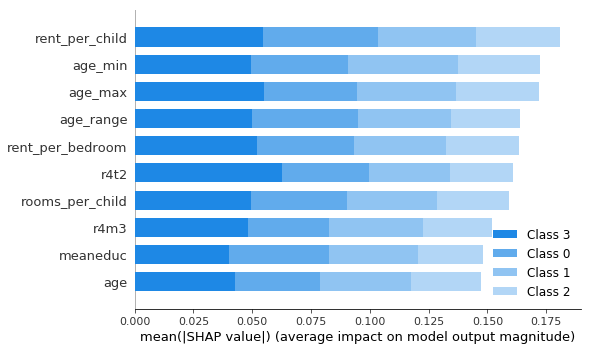

In [19]:
shap.summary_plot(shap_values, feature_names=X_train.columns, max_display=10)

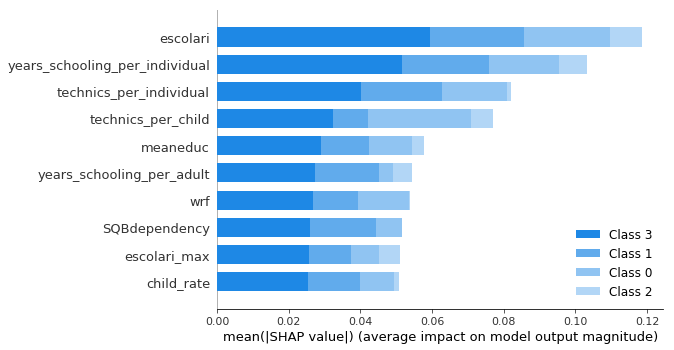

In [20]:
rf_inter = shap.TreeExplainer(random_forest)
shap_values_tree = rf_inter.shap_values(example_row)
shap.summary_plot(shap_values_tree, example_row, max_display=10)

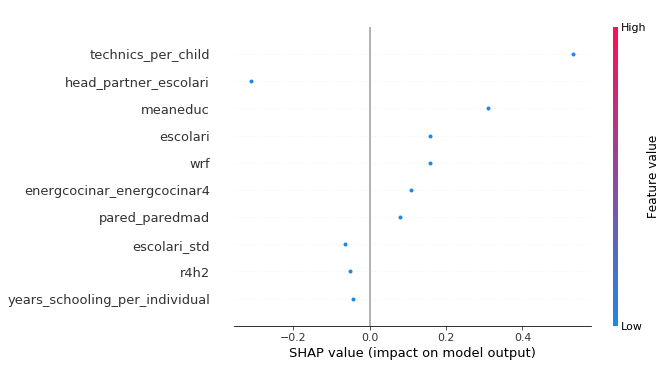

In [21]:
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_tree_lgb = explainer_lgb.shap_values(example_row)
shap.summary_plot(shap_values_tree_lgb, example_row, max_display=10)

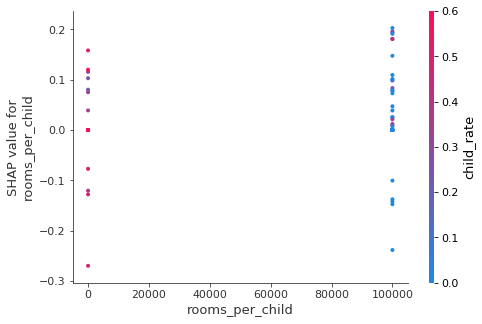

In [40]:
shap.dependence_plot('rooms_per_child', np.array(shap_values[0]), X_val)

LIME (https://arxiv.org/abs/1606.05386)

In [26]:
class_names = ['extreme poverty', 'moderate poverty', 'vulnerable households', 'non vulnerable households']

In [27]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, 
                                                discretize_continuous=True, class_names=class_names)

In [28]:
exp = explainer.explain_instance(example_row.iloc[0], random_forest.predict_proba, num_features=10, top_labels=1)

In [29]:
exp.show_in_notebook(show_table=True, show_all=False)

This model works well with text data!!!